In [2]:
from ete3 import Tree
from ete3.treeview import faces, AttrFace, TextFace, TreeStyle, NodeStyle, CircleFace, RectFace

# python libraries
import pickle
import itertools
import random
import os


# scipy
import scipy.stats
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# sklearn
from sklearn import manifold
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.utils import check_random_state
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import f1_score

# clustering
from sklearn.cluster import DBSCAN
import hdbscan

# statistics
import mantel

# plotting
import matplotlib.gridspec as gridspec
from matplotlib.collections import PolyCollection
import matplotlib
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.colors import to_hex

# additional plotting code
import sys
import time
sys.path.append('/data/mhoffert/fiererlab/periodic_phyla/code/')

from tufte_box import *

# displays
from IPython.display import display, clear_output

# ENS-t-SNE
sys.path.append('/data/mhoffert/tools/MPSE-TSNE/ENS-t-SNE/')
import mview

# for visualizing trees
os.environ['QT_QPA_PLATFORM']='offscreen'

## Outline
Finalized code to make the periodic table figure.

In [3]:
import ete3 as ete3
ete3.__version__

'3.1.2'

## Actually used imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [25]:
import sys
import pickle

# data
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import scale, StandardScaler


## Load GTDB data

In [6]:
sys.path = ['/data/mhoffert/tools/ete/'] + sys.path[:-1]
sys.path.append('./../code/')

In [7]:
import gtdb

In [8]:
%%time
# get gtdb metadata and version containing only phyla with 100+ species
md, md_top_phyla = gtdb.load_gtdb('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv')

Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 11.1 s, sys: 2 s, total: 13.1 s
Wall time: 41.2 s


In [9]:
# get a list of the most abundant phyla
most_abundant_phyla = md_top_phyla.groupby(['Phylum']).count().sort_values('accession', ascending=False).head(10)
print(most_abundant_phyla['accession'])

Phylum
Proteobacteria       17350
Bacteroidota          8588
Firmicutes_A          8243
Actinobacteriota      7328
Firmicutes            4216
Patescibacteria       2485
Chloroflexota         1387
Cyanobacteria         1372
Verrucomicrobiota     1325
Planctomycetota       1071
Name: accession, dtype: int64


In [10]:
md['ncbi_isolation_source'].value_counts()

ncbi_isolation_source
none                                      56895
soil                                        306
biological product [ENVO:02000043]          171
derived from human gut metagenome           156
not provided; submitted under MIGS 2.1      136
                                          ...  
a paper mill waste water polluted pond        1
soil sediment                                 1
grasslands                                    1
soil of a rice field                          1
host s whole body                             1
Name: count, Length: 2026, dtype: int64

## Load trait data

In [14]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230814_pca_data.pickle', 'rb') as handle:
    pca_data = pickle.load(handle)

In [15]:
pca_data.index = [i.replace('.', '_') for i in pca_data.index]

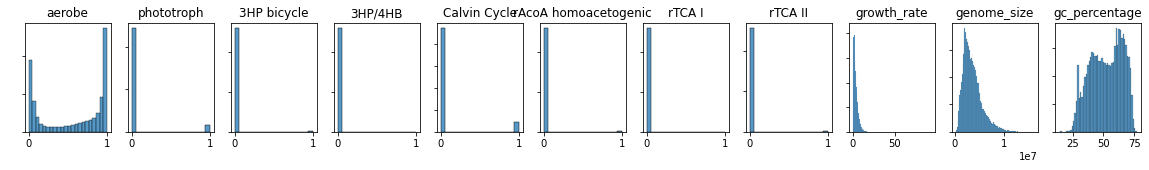

In [20]:
'''
Identify candidate data points for removal
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in pca_data.columns:
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(pca_data[col].values, ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

Looks like some things need to be filtered based on growth rate

### Remove observations with extremely high growth rate

In [21]:
# 
print(pca_data.shape)
pca_data = pca_data[pca_data['growth_rate'] < 25]
print(pca_data.shape)

(51880, 11)
(51851, 11)


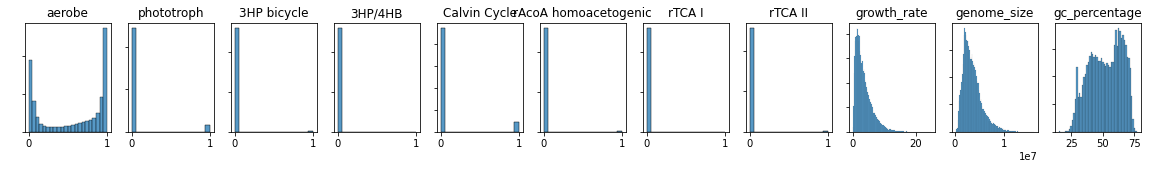

In [22]:
'''
Identify candidate data points for removal
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in pca_data.columns:
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(pca_data[col], ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

### Scale data

In [26]:
# scaling individual columns in the data
def scale_func(x, xname):
    # print(f'scaling {xname}')
    return scale(x)

# only scaling some columns
to_scale_vars = ['growth_rate', 'genome_size', 'gc_percentage']
pca_data.head().apply(lambda x: scale_func(x, x.name) if x.name in to_scale_vars else x)

,aerobe,phototroph,3HP bicycle,3HP/4HB,Calvin Cycle,rAcoA homoacetogenic,rTCA I,rTCA II,growth_rate,genome_size,gc_percentage
GB_GCA_000007325_1,0.001817,0,0.0,0.0,0.0,0.0,0.0,0.0,0.556748,-0.026066,-0.710654
GB_GCA_000008885_1,0.470498,0,0.0,0.0,0.0,0.0,0.0,0.0,0.735718,-1.115905,-1.049117
GB_GCA_000009845_1,0.682832,0,0.0,0.0,0.0,0.0,0.0,0.0,1.045784,-1.004745,-0.666624
GB_GCA_000010085_1,0.865893,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.569988,1.542596,1.269066
GB_GCA_000010565_1,0.018416,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.768261,0.604120,1.157329


In [28]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/trees/GTDB_full_tip_dist_matrix_rownames.txt', 'r') as handle:
    row_names_lines = handle.readlines()

row_names = [r.strip().replace('"', '') for r in row_names_lines[1:]]
row_names_series = pd.Series(row_names)

In [29]:
# list of genomes in phyla with at least 100 representatives
top_phyla_genome_accs = md_top_phyla['accession_reformat'].unique()

# vector of T/F for leaves in the trait data used to subset distance matrix
keep_rows = np.array([r in pca_data.index and r in top_phyla_genome_accs for r in row_names])

# same as above, used to reindex trait data
keep_rows_names = np.array([r for r in row_names if r in pca_data.index and r in top_phyla_genome_accs])

In [30]:
# scale and take values as floats
np_pca_data = pca_data.apply(lambda x: scale_func(x, x.name) if x.name in to_scale_vars else x).reindex(keep_rows_names).astype(float)

np_pca_data.head()

,aerobe,phototroph,3HP bicycle,3HP/4HB,Calvin Cycle,rAcoA homoacetogenic,rTCA I,rTCA II,growth_rate,genome_size,gc_percentage
GB_GCA_012517545_1,0.012481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.120779,-0.637998,-1.708150
GB_GCA_017540815_1,0.008260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867855,-0.264948,-0.797864
GB_GCA_001829125_1,0.046911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404638,0.426372,-1.989249
GB_GCA_009784515_1,0.081483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.767524,-0.915710,-0.887366
GB_GCA_016936615_1,0.052110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.436930,-0.170182,-1.136206


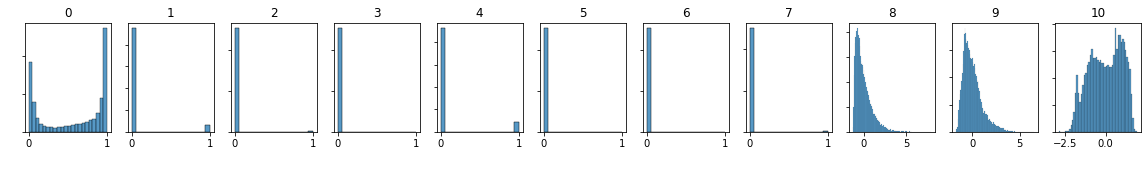

In [31]:
'''
plotting scaled data
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in range(len(pca_data.columns)):
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(np_pca_data.values[:, col], ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

In [32]:
np_pca_data.shape #, patristic_distance_matrix.shape

(50745, 11)

## Saving finalized trait data

In [34]:
pca_data.to_csv('./../finalized_data/20241127_trait_data.tsv.gz', 
                sep='\t', 
                compression='gzip')

In [35]:
np_pca_data.to_csv('./../finalized_data/20241127_scaled_trait_data.tsv.gz', 
                sep='\t', 
                compression='gzip')

## Loading in the tree

In [24]:
gtdb_full = Tree('/data/mhoffert/genomes/GTDB_r207/tree/bac120_r207.tree', format=1, quoted_node_names=True)

### Reformatting tree

In [25]:
# rename internal nodes
names_map = []
i = 0
for node in gtdb_full.traverse(strategy='levelorder'):
    if i % 500 == 0:
        display(i)
        clear_output(wait=True)
    if not node.is_leaf():
        new_node_name = f'c{i:06}'
        names_map.append((new_node_name, node.name))
        node.name = new_node_name
    else:
        names_map.append((node.name.replace('.', '_'), node.name))
        node.name = node.name.replace('.', '_')
    i += 1

124500

In [26]:
# make a series
names_map = pd.Series(dict(names_map))

In [27]:
phylum_counts.sort_values(ascending=False)

Phylum
Proteobacteria        17350
Bacteroidota           8588
Firmicutes_A           8243
Actinobacteriota       7328
Firmicutes             4216
Patescibacteria        2485
Chloroflexota          1387
Cyanobacteria          1372
Verrucomicrobiota      1325
Planctomycetota        1071
Desulfobacterota        939
Acidobacteriota         873
Spirochaetota           695
Campylobacterota        550
Firmicutes_C            395
Myxococcota             393
Firmicutes_B            323
Nitrospirota            314
Omnitrophota            282
Gemmatimonadota         237
Desulfobacterota_I      236
Bdellovibrionota        224
Elusimicrobiota         189
Marinisomatota          186
Chlamydiota             171
Deinococcota            144
Armatimonadota          139
Synergistota            132
Firmicutes_G            131
Fibrobacterota          120
Firmicutes_D            104
Name: accession, dtype: int64

## Plotting phylum selection to try to find conserved clades of microbes

In [28]:
# create a version of gtdb tree with only clades of interest
gtdb_pruned = gtdb_full.copy()

gtdb_pruned.prune(np_pca_data.index)

gtdb_pruned.describe()

Number of leaf nodes:	50745
Total number of nodes:	101489
Rooted:	Yes
Most distant node:	RS_GCF_000008205_1
Max. distance:	2.646470


In [29]:
'''
Getting the clade in the tree for each phylum: a little tricky because of deleted nodes.
'''
top_phyla_clades = pd.concat([names_map[names_map.str.contains(f'p__{p}$') | names_map.str.contains(f'p__{p};')] for p in top_phyla])
rename_dict = {}
for c in top_phyla_clades.index:
    # if it was removed from the tree
    if len(gtdb_pruned.search_nodes(name=c)) < 1:
        print('Deleted node found: ', c, top_phyla_clades.loc[c])
        # go up tree until a node is found
        result = []
        new_node = gtdb_full.search_nodes(name=c)[0]
        levels = 0
        print('Finding unpruned parent node:')
        while len(result) < 1:
            new_node = new_node.up
            result = gtdb_pruned.search_nodes(name=new_node.name)
            levels += 1
        print('New node found: ', new_node.name, f'{levels} levels above original node {c}')
        
        # confirm new node's children are mostly this clade
        print('Checking leaf numbers: ')
        node = gtdb_full.search_nodes(name=c)[0]
        while node.name != new_node.name:
            print('\t', node.name, [len(c.get_leaves()) for c in node.get_children()], f' found in pruned: {len(gtdb_pruned.search_nodes(name=node.name)) > 0}')
            node = node.up
        print('\t', node.name, [len(c.get_leaves()) for c in node.get_children()], f' found in pruned: {len(gtdb_pruned.search_nodes(name=node.name)) > 0}')    
        new_node_pruned = gtdb_pruned.search_nodes(name=new_node.name)[0]
        print('\tChildren: ', [c.name for c in new_node_pruned.get_children()], 'Leaf counts: ', [len(c.get_leaves()) for c in new_node_pruned.get_children()])
        
        print('Finding child of deleted node: ')
        for node in gtdb_full.search_nodes(name=c)[0].traverse('levelorder'):
            print('\t', len(node.get_leaves()))
            if len(gtdb_pruned.search_nodes(name=node.name)) > 0:
                print(f'\tfound: {node.name}')
                break

        new_node_child_names = [c.name for c in new_node_pruned.get_children()]
        print(node.name in new_node_child_names)
        print(f'Assigning new node {node.name} as representative of {c}')
        rename_dict[c] = node.name
        print()

Deleted node found:  c000892 100.0:p__Chlamydiota; c__Chlamydiia
Finding unpruned parent node:
New node found:  c000444 2 levels above original node c000892
Checking leaf numbers: 
	 c000892 [1, 170]  found in pruned: False
	 c000640 [13, 171]  found in pruned: False
	 c000444 [1325, 184]  found in pruned: True
	Children:  ['c000639', 'c001220'] Leaf counts:  [822, 90]
Finding child of deleted node: 
	 171
	 1
	 170
	found: c001220
True
Assigning new node c001220 as representative of c000892

Deleted node found:  c000285 100.0:p__Deinococcota; c__Deinococci
Finding unpruned parent node:
New node found:  c000194 1 levels above original node c000285
Checking leaf numbers: 
	 c000285 [1, 143]  found in pruned: False
	 c000194 [144, 7328]  found in pruned: True
	Children:  ['c000286', 'c000420'] Leaf counts:  [7048, 140]
Finding child of deleted node: 
	 144
	 1
	 143
	found: c000420
True
Assigning new node c000420 as representative of c000285

Deleted node found:  c008059 100.0:p__Desulfo

In [30]:
top_phyla_clades = top_phyla_clades.rename(index=rename_dict)

# Generating variances explained for wavelets

In [62]:
# copy of Evan's code to construct centered wavelet coefficients
BASE_PATH = "/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/Trait_project/"
tree = Tree(f"{BASE_PATH}gtdb_tree.nw", format=1, quoted_node_names=True)
tree.name = 'c000000'

In [63]:
tree.get_children()

[Tree node 'c000001' (0x7f5fe33fb8b), Tree node 'c000014' (0x7f6003427ac)]

In [64]:
#Traverse the tree to collect internal node names
internalnodes=[]
i=0
for node in tree.traverse("postorder"):
    if not node.is_leaf():
        internalnodes.append(node.name)
        i=i+1
        
#Add the outrooting (corresponds to "scaling" wavelet)        
internalnodes.append("outroot")

In [65]:
trait_data=pd.read_csv(f'{BASE_PATH}trait_data.tsv',sep='\t') 
traits=trait_data.columns[1:]
trait_data = trait_data.drop('Unnamed: 0', axis=1)

#Mean-center each trait
trait_data_centered=trait_data.apply(lambda x: x-x.mean())

#Load wavelet transform
haarlike=scipy.sparse.load_npz(f'{BASE_PATH}Haarlike.npz')

#Recover the wavelet coefficients for each centered trait
waveletcoefs_centered=np.zeros((11,50745))
i=0
for column in trait_data_centered.columns:
    if column !='Unnamed: 0':
        subdata=[]
        subdata.append(column)
        trait=trait_data_centered[column].values
        wavelet=haarlike@trait
        waveletcoefs_centered[i,:]=wavelet
        i=i+1


waveletcoefficients_centered=pd.DataFrame(data=waveletcoefs_centered, index=traits, columns=internalnodes)  

In [66]:
trait_data.head()

,aerobe,phototroph,3HP bicycle,3HP/4HB,Calvin Cycle,rAcoA homoacetogenic,rTCA I,rTCA II,growth_rate,genome_size,gc_percentage
0,0.012481,0,0.0,0.0,0.0,0.0,0.0,0.0,3.180542,2358896,30.427073
1,0.008260,0,0.0,0.0,0.0,0.0,0.0,0.0,1.161323,3074498,42.095165
2,0.046911,0,0.0,0.0,0.0,0.0,0.0,0.0,4.600653,4400620,26.823927
3,0.081483,0,0.0,0.0,0.0,0.0,0.0,0.0,5.581473,1826176,40.947915
4,0.052110,0,0.0,0.0,0.0,0.0,0.0,0.0,2.326041,3256282,37.758278


In [67]:
waveletcoefficients_centered.head()

,c000214,c000145,c000098,c000018,c000096,c000058,c000034,c000008,c002311,c001263,...,c012988,c004769,c002192,c001622,c000869,c000088,c000028,c000014,c000000,outroot
aerobe,-0.027331,-0.012333,-5.103687e-02,-0.013261,-0.022323,-0.025685,-1.572339e-02,-7.182927e-03,-0.091844,0.160925,...,0.371015,3.996640e-01,1.249661e-01,3.071765e-01,-7.538879e-02,-0.643498,-29.234253,-9.868189,-7.048139,1.014228e-13
phototroph,0.000000,0.000000,6.938894e-18,0.000000,0.000000,0.000000,-6.938894e-18,-6.938894e-18,-0.707107,0.408248,...,0.000000,-1.387779e-17,-3.469447e-18,4.062558e-02,-1.197626e-02,0.584615,-2.717147,-1.556815,-1.192106,2.312874e-12
3HP bicycle,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-4.336809e-19,-4.336809e-19,0.000000,0.000000,...,0.000000,-8.673617e-19,0.000000e+00,1.344411e-17,5.692061e-19,0.066179,-0.607449,-0.115033,-0.095354,5.275525e-13
3HP/4HB,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-2.168404e-19,0.000000e+00,0.000000,0.000000,...,0.000000,-4.336809e-19,-3.252607e-19,-9.324139e-18,1.138412e-18,0.031104,-0.289830,-0.053650,-0.044472,-1.554456e-13
Calvin Cycle,0.000000,0.000000,1.387779e-17,0.000000,0.000000,0.000000,-6.938894e-18,-4.163336e-17,0.000000,0.000000,...,0.000000,-1.387779e-17,1.040834e-17,-3.400058e-16,-7.632783e-17,1.137290,-7.977920,-1.966558,-1.689400,4.852886e-12


In [68]:
%%time
# Calculate explained variance for each trait
# old code 
# explained_variance = np.zeros((11, 50745))
# for i in range(11):
#     percentages=[]
#     #Sort the wavelet coefficients in descending order
#     wavecoefssort=-np.sort(-abs(waveletcoefs_centered[i,:]))
#     for j in range(50745):
#         #Compute percent variance explained
#         percentages.append(np.linalg.norm(wavecoefssort[0:j])/np.linalg.norm(trait_data_centered.iloc[:,i].values))
#     explained_variance[i, :] = percentages


# Absolute value method you were doing 
# old code
# explained_absval=np.zeros((11,50745))
# for i in range(11):
#     percentages=[]
#     #Sort the wavelet coefficients in descending order
#     wavecoefssort=-np.sort(-abs(waveletcoefs_centered[i,:]))
#     for j in range(50745):
#         #Compute percent variance explained
#         percentages.append(np.sum(wavecoefssort[0:j])/np.sum(wavecoefssort))
#     explained_absval[i,:]=percentages


varexp = []
varexp_abs = []
for trait, row in waveletcoefficients_centered.iterrows():
    print(trait)
    
    # sorted absolute value version
    abs_sort = row.apply(np.abs).sort_values(ascending=False)
    
    # calculate variances explained
    # denominator: norm of trait data
    denom = np.linalg.norm(trait_data_centered.loc[:, trait].values)
    norms = [np.linalg.norm(abs_sort.iloc[0:i]) / denom for i in range(len(abs_sort))]
    
    total_abs = abs_sort.sum()
    norms_abs = [abs_sort.iloc[0:i].sum() / total_abs for i in range(len(abs_sort))]
        
    # add series per trait
    varexp.append(pd.Series(name=trait, 
                            index=abs_sort.index,
                            data=norms))
    
    # add series per trait
    varexp_abs.append(pd.Series(name=trait, 
                            index=abs_sort.index,
                            data=norms_abs))
    
    

aerobe
phototroph
3HP bicycle
3HP/4HB
Calvin Cycle
rAcoA homoacetogenic
rTCA I
rTCA II
growth_rate
genome_size
gc_percentage
CPU times: user 15min, sys: 19min 35s, total: 34min 36s
Wall time: 2min 13s


In [69]:
# calculate individual variances explained by subtracting each data from previous point
varexp_ind = []
varexp_abs_ind = []
for vec, vec_abs in zip(varexp, varexp_abs):
    print(vec.name)
    a = vec.drop('outroot').iloc[1:]
    b = vec.drop('outroot').iloc[:-1]
    varexp_ind.append(pd.Series(index=b.index, data=a.values - b.values, name=vec.name))
    
    a = vec_abs.drop('outroot').iloc[1:]
    b = vec_abs.drop('outroot').iloc[:-1]
    varexp_abs_ind.append(pd.Series(index=b.index, data=a.values - b.values, name=vec_abs.name))


aerobe
phototroph
3HP bicycle
3HP/4HB
Calvin Cycle
rAcoA homoacetogenic
rTCA I
rTCA II
growth_rate
genome_size
gc_percentage


In [70]:
varexp_ind_df = pd.concat(varexp_ind, axis=1).fillna(0)
varexp_ind_abs_df = pd.concat(varexp_abs_ind, axis=1)

In [71]:
varexp_ind_rank_df = pd.concat([i.reset_index(drop=True) for i in varexp_ind], axis=1).fillna(0)
varexp_ind_rank_abs_df = pd.concat([i.reset_index(drop=True) for i in varexp_abs_ind], axis=1)
varexp_ind_rank_df

,aerobe,phototroph,3HP bicycle,3HP/4HB,Calvin Cycle,rAcoA homoacetogenic,rTCA I,rTCA II,growth_rate,genome_size,gc_percentage
0,3.646121e-01,0.301664,0.101311,0.124410,0.223044,0.137168,0.159423,0.122057,2.605792e-01,3.122489e-01,4.970016e-01
1,1.236714e-01,0.073532,0.039811,0.049028,0.075113,0.055165,0.057262,0.046147,7.826341e-02,5.209855e-02,6.790223e-02
2,4.718858e-02,0.045727,0.028940,0.032377,0.051691,0.039675,0.043633,0.024729,6.095595e-02,4.336223e-02,3.772745e-02
3,4.063921e-02,0.034255,0.024432,0.027419,0.029243,0.031209,0.036742,0.018113,2.446363e-02,3.797500e-02,2.684838e-02
4,2.597832e-02,0.024809,0.018606,0.016978,0.022100,0.019958,0.032381,0.012033,1.780103e-02,2.835931e-02,2.532633e-02
...,...,...,...,...,...,...,...,...,...,...,...
50738,5.551115e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.030110e-14,1.276756e-14,1.887379e-15
50739,2.220446e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.320366e-14,1.254552e-14,1.443290e-15
50740,4.440892e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.754152e-14,1.776357e-15,7.771561e-16
50741,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.330669e-15,6.661338e-16,9.992007e-16
